# Project 3: More Classication

## Part 1: Acquire and Partition Data (5 points)

In [1]:
import numpy as np 
import random
import matplotlib.pyplot as plt
import math

# Set to 1 to standardize, 0 to not standardize
STD = 1

In [2]:
# Getting the Data via Python
data   = np.loadtxt('sonar5841.dat')
# Shuffle the data
np.random.shuffle(data)
data_x = data[:,0:-1]
data_y = data[:,-1]
print('shape of data_x:',data_x.shape)
print('shape of data_y',data_y.shape)

shape of data_x: (208, 60)
shape of data_y (208,)


In [3]:
# X data represent the energy over 60 bands ranging from 0 to 1
# Y data represent the classes, either rock or metal detected
#
# There are 111 metal and 97 rock
# http://archive.ics.uci.edu/ml/datasets/connectionist+bench+(sonar,+mines+vs.+rocks)

# Partitioning the Data
test_data_x = data_x[0:41]
test_data_y = data_y[0:41]

train_data_x = data_x[41:-1]
train_data_y = data_y[41:-1]

# Standardizing
train_x_mean = np.mean(train_data_x)
train_x_std  = np.std(train_data_x)
train_x_mean, train_x_std

if STD:
    train_data_x = (train_data_x - train_x_mean)/train_x_std
    test_data_x = (test_data_x - train_x_mean)/train_x_std
    
print(train_data_x[0])

[-0.91348939 -0.86424705 -0.97996656 -0.86213666 -0.83399817 -0.4833223
 -0.21635843 -0.57617931 -0.73023751 -0.42036244 -0.04119636  0.1870771
  0.44489597  0.55358087  0.93520907  1.54300035  1.86799985  2.236614
  2.52327482  2.31856734  2.21234456  2.29429789  1.63831946  0.81597224
  0.45017193  0.21697424  1.46139874  2.07059694  2.17611626  1.82473693
  0.54654625 -0.53010254 -0.39292742 -0.12033585  0.07663355 -0.18083359
 -0.52341965 -0.27087674 -0.12385316 -0.01270614 -0.4277488  -0.97433887
 -0.8705782  -0.59024855 -0.52588176 -0.89695803 -0.72566501 -0.77209351
 -0.88535091 -0.90962035 -0.95358674 -0.97152502 -0.98629772 -0.95112462
 -0.94092442 -0.97433887 -0.9848908  -0.98383561 -0.95745578 -0.93670364]


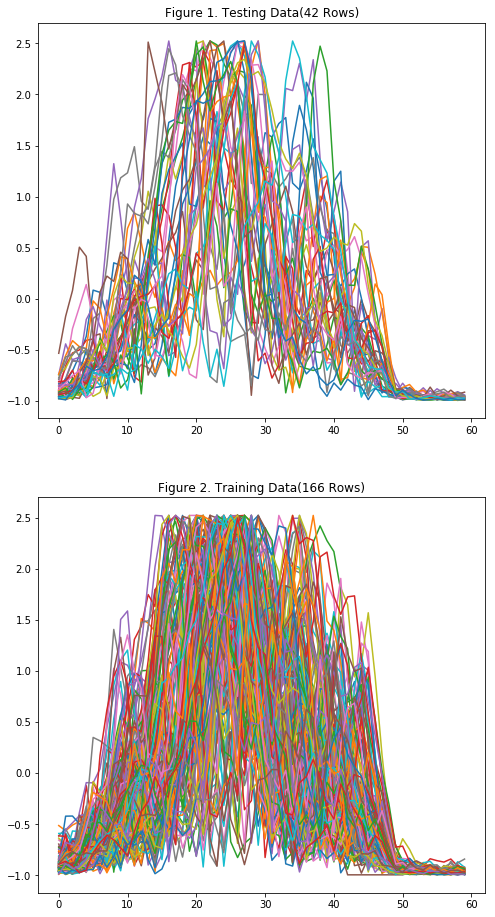

In [4]:
# Plotting
f1 = plt.figure(1, figsize=(8,16))
f1.clf()
test_data_plot  = f1.add_subplot(211)
test_data_plot.set_title("Figure 1. Testing Data(42 Rows)")
train_data_plot = f1.add_subplot(212)
train_data_plot.set_title("Figure 2. Training Data(166 Rows)")

for i in test_data_x:
    test_data_plot.plot(i)
for i in train_data_x:
    train_data_plot.plot(i)

### Logistic Regression

In [5]:
def IRLS(data_x, data_y):
    length        = len(data_x)
    not_converged = True
    w             = np.zeros(61)
    p             = np.empty(length)
    s             = np.empty(length)
    z             = np.empty(length)

#     ones          = np.ones(200)
#     ones[100:]    = ones[100:]*-1
    
#     temp_var      = np.hstack((ones[None].T,data_x))
#     np.random.shuffle(temp_var)
    
    y             = data_y
    data          = data_x
    print('Data shape is', data.shape, "data.T:",data.T.shape)
    
    i_count = 0
    while not_converged:
        
        w_prev = w
        for i in range(length):
            p[i] = np.exp(w_prev.dot(data[i])) / (1 + np.exp(w_prev.dot(data[i])))
            s[i] = p[i]*(1-p[i])          
#             if math.isnan(s[i]): s[i]=1
            z[i] = w_prev.dot(data[i]) + (y[i]-p[i])/(max(s[i],0.00001))
#         print("shape of z:", z.shape)
        diag_s = np.diag(s)
#         print("diag_s:",diag_s.shape)
        t1     = np.linalg.inv(np.dot(np.dot(data.T, diag_s), data))
#         print("t1 shape", t1.shape)
        t2     = np.dot(np.dot(data.T, diag_s), z)
#         print("t1 and t2", t1.shape, t2.shape)
        # Here w should be (61,), t1(61,x), t2(x,1)
        w      = np.dot(t1, t2)
        w      = w/np.linalg.norm(w)
        
        i_count = i_count + 1
        print('Iterations',i_count)
        
        if abs(sum(w-w_prev)) < 0.000001:
            
            print("Converged!!")
            not_converged = False
            return w
            
        elif sum(abs(w)) > 900 or math.isnan(w[0]):
            
            print("Not converging!!!")
            return w
            
    return w

In [6]:
ones = np.ones(len(train_data_x))[None].T
train_data_x_1s = np.hstack((ones, train_data_x))

In [7]:
result = IRLS(train_data_x_1s, train_data_y)

Data shape is (166, 61) data.T: (61, 166)
Iterations 1
Iterations 2
Iterations 3
Converged!!


In [8]:
def LR_prob(w,x):
#     w = w[None].T
    term1 = np.exp(np.dot(x,w))
    term2 = 1 + np.exp(np.dot(x,w))
    prob  = term1/term2
    
    return prob

def LR_accuracy(x, y, result):
    ones = np.ones(len(x))[None].T
    x = np.hstack((ones, x))
    
    prob = LR_prob(result, x)
    # LR results
    LR_results = prob>0.5
    # Ground Truth
    OG_results = y>0
    # Comparing these 2 results
    acc = (sum(~np.logical_xor(LR_results,OG_results))-1)/(len(y)-1)
    
    return acc

In [9]:
LR_result = LR_accuracy(test_data_x, test_data_y, result)
print("Accuracy of Logistic regression: ", LR_result)

Accuracy of Logistic regression:  0.45


### Linear SVM

In [10]:
from sklearn import svm
import operator

In [11]:
def data_partition(data_x, data_y, n):
    # combining x and y
    data = np.hstack((data_x,data_y[None].T))
    # shuffling data
    np.random.shuffle(data)
    # deviding data into 5 parts
    batch_size = int(len(data_y)/n) + 1 # +1 so we won't have a batch with 1 element in the end
#     print("Total length is", len(data_y), "batch size is",batch_size)
    data_p = []
    for i in range(n):

        end = i*batch_size+batch_size
#         print(i)
        if end < len(data_y):
            data_p.append(data[i*batch_size:end])
#             print("start",i*batch_size, "end", end)
        else:
            data_p.append(data[i*batch_size:end])
#             print("start",i*batch_size, "end --", )

    data_p_x = []
    data_p_y = []
    for i in range(len(data_p)):
        
        data_p_x.append(data_p[i][:,0:-1])
        data_p_y.append(data_p[i][:,-1])
    
    return np.array(data_p_x), np.array(data_p_y)

def cross_validation(data_x, data_y, n, kernel, c):
    
    # partition data
    x,y = data_partition(data_x, data_y, n)
    # generating bollean mask
    bool_mask = np.diag(np.ones(n))
    bool_mask = (1 - bool_mask) > 0
    acc = []
    # extract each fold using boolean mask
    for i in range(n):
        xtrain = np.concatenate(x[bool_mask[i]])
        ytrain = np.concatenate(y[bool_mask[i]])
        xtest = np.concatenate(x[~bool_mask[i]])
        ytest = np.concatenate(y[~bool_mask[i]])
        if (kernel == 'linear'):
            svm_model = svm.LinearSVC(max_iter=5000, C=c)
        elif (kernel == 'kernel'):
            svm_model = svm.SVC(gamma=c, max_iter=5000)
            
        svm_model.fit(xtrain, ytrain)
        acc.append(svm_model.score(xtest, ytest))
    
#     print(acc)
    return np.mean(acc)

In [12]:
# iterate some Cs
x = []
c_vector = np.linspace(0.001,5,100)
for i in c_vector:
    x.append(cross_validation(data_x, data_y, 5, 'linear', i))

index, max_x = max(enumerate(x), key=operator.itemgetter(1))
print("Maximun accuracy(",max_x,") occurs when C equals to", c_vector[index])

Maximun accuracy( 0.8028571428571428 ) occurs when C equals to 1.6673333333333331


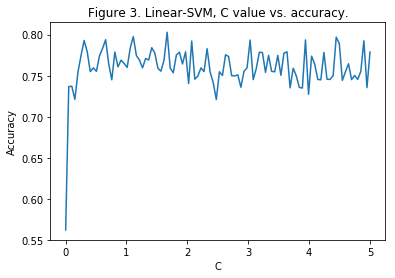

In [13]:
fig2 = plt.figure(2)
plot2 = fig2.add_subplot(111)
plot2.set_title("Figure 3. Linear-SVM, C value vs. accuracy.")
plot2.plot(c_vector,x)
plot2.set_xlabel("C")
plot2.set_ylabel("Accuracy")
plt.show()

In [14]:
# index, value = max(enumerate(x), key=operator.itemgetter(1))

In [15]:
# test = np.array([12,3,2,1,4,53,4,5,6])

In [16]:
# gettor = operator.itemgetter(0)
# gettor(test)

### Kernel SVM

In [17]:
gamma_vector = np.linspace(0.0001,5,100)
kernelSVM_acc = []
for gamma in gamma_vector:
    kernelSVM_acc.append(cross_validation(data_x, data_y, 5, 'kernel', gamma))

index, max_gamma = max(enumerate(kernelSVM_acc), key=operator.itemgetter(1))
print("Maximun accuracy(",max_gamma,") occurs when Gamma equals to", gamma_vector[index])

Maximun accuracy( 0.8842857142857143 ) occurs when Gamma equals to 1.616229292929293


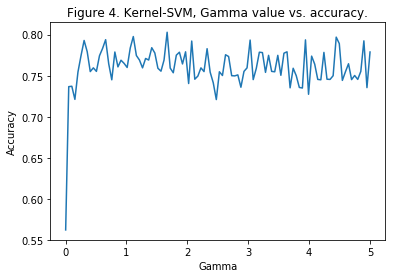

In [18]:
fig3 = plt.figure(3)
plot3 = fig3.add_subplot(111)
plot3.set_title("Figure 4. Kernel-SVM, Gamma value vs. accuracy.")
plot3.plot(c_vector,x)
plot3.set_xlabel("Gamma")
plot3.set_ylabel("Accuracy")
plt.show()